In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as gb
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras import optimizers
import json
import cv2
import seaborn as sns
from scipy.stats import norm
import statistics
import random
import shutil
import _utils as fn
%matplotlib inline

In [2]:
train_dir = './train4/'
valid_dir = './valid4/'

In [3]:
## Check image amount each folder
trainDir_list = []
for folder in os.listdir(train_dir):
  files = gb.glob(train_dir+folder+'/')
  for file in files:
    trainDir_list.append(str(file))
    print(folder,':',len(os.listdir(str(file))))

Bacterial_spot : 3050
Early_blight : 3060
healthy : 3048
Septoria_leaf_spot : 3073
Target_Spot : 3075
Tomato_Yellow_Leaf_Curl_Virus : 3060


In [4]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

['Bacterial_spot', 'Early_blight', 'Septoria_leaf_spot', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'healthy']


In [5]:
n_classes = len(class_names)
print(n_classes)

6


[3050, 3060, 3073, 3075, 3060, 3048]
max is  3075 
min is  3048


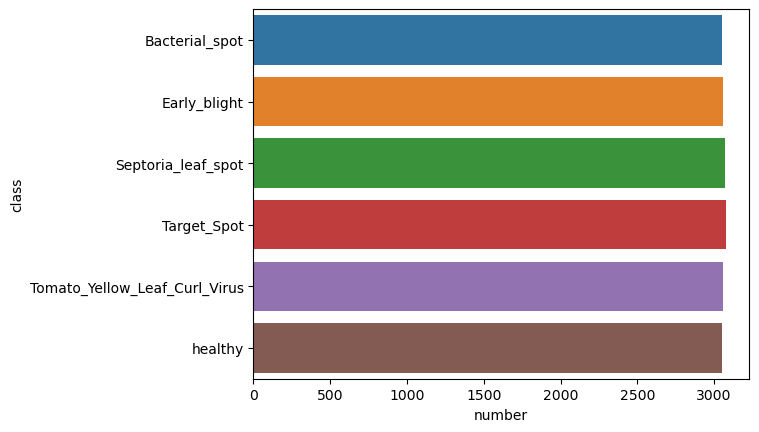

In [6]:
count=[]
for number in class_names :
    count.append(len(os.listdir(train_dir+number)))
print(count)

df = pd.DataFrame({'class':class_names, 'number':count})
g=sns.barplot(data=df,x='number', y='class')

print('max is ',max(count),'\nmin is ',min(count))
# g.set_xticklabels(g.get_xticklabels(), rotation=90) 

[828, 803, 810, 809, 818, 802]
max is  828 
min is  802


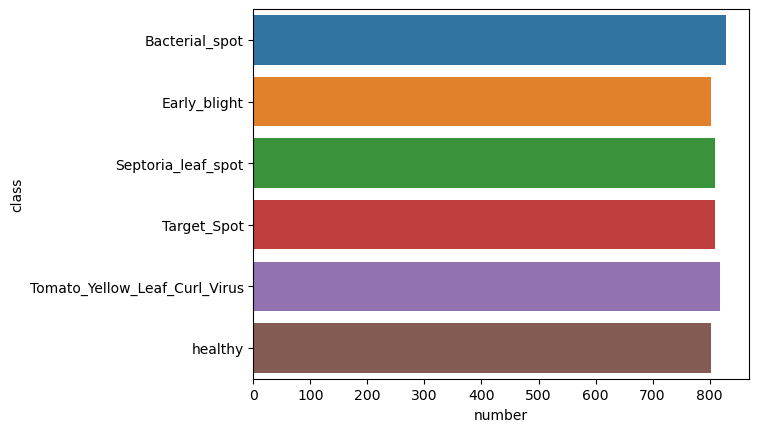

In [7]:
count2=[]
for number in class_names :
    count2.append(len(os.listdir(valid_dir+number)))
print(count2)

df = pd.DataFrame({'class':class_names, 'number':count2})
g=sns.barplot(data=df,x='number', y='class')

print('max is ',max(count2),'\nmin is ',min(count2))
# g.set_xticklabels(g.get_xticklabels(), rotation=90) 

In [8]:
batch_size = 32
img_height = 100
img_width = 100

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle = True,
    color_mode="rgb",
    seed=42,
    subset='training')

validation_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle = True,
    color_mode="rgb",
    seed=42,
    subset='validation')

test_ds = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    color_mode="rgb",
    seed=42,
    class_mode=None)

Found 14694 images belonging to 6 classes.
Found 3672 images belonging to 6 classes.
Found 4870 images belonging to 6 classes.


In [11]:
class_names = train_ds.class_indices
print(class_names)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Septoria_leaf_spot': 2, 'Target_Spot': 3, 'Tomato_Yellow_Leaf_Curl_Virus': 4, 'healthy': 5}


#### Build Model

In [12]:
target_input = (img_height,img_width,3)

In [13]:
from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=target_input)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [14]:
vgg.trainable = True
for layer in vgg.layers[:11]:
    if layer.name[:11] == 'block5_conv':
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
vgg16 = models.Sequential()
vgg16.add(vgg)
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_uniform',
                     name='fully_connect_1'
                    ))

vgg16.add(layers.Dropout(0.5,name='dropout_2'))
vgg16.add(layers.Dense(n_classes,activation='softmax',
                     kernel_initializer='he_uniform',
                     name='output'
                    ))

vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 fully_connect_1 (Dense)     (None, 128)               589952    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 6)                 774       
                                                                 
Total params: 15,305,414
Trainable params: 13,569,926
Non-trainable params: 1,735,488
_________________________________________________________________


In [16]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=1e-6)
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [17]:
opt = optimizers.Adam(learning_rate=1e-4)
vgg16.compile(optimizer=opt,
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [18]:
history = vgg16.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=10,
  steps_per_epoch=len(train_ds), 
  validation_steps=len(validation_ds)
)

Epoch 1/10
460/460 [==============================] - 103s 211ms/step - loss: 0.7438 - accuracy: 0.7213 - val_loss: 0.5452 - val_accuracy: 0.8173
Epoch 2/10
460/460 [==============================] - 90s 195ms/step - loss: 0.3800 - accuracy: 0.8696 - val_loss: 0.2078 - val_accuracy: 0.9229
Epoch 3/10
460/460 [==============================] - 90s 196ms/step - loss: 0.2903 - accuracy: 0.8984 - val_loss: 0.5111 - val_accuracy: 0.8576
Epoch 4/10
460/460 [==============================] - 90s 196ms/step - loss: 0.2337 - accuracy: 0.9191 - val_loss: 0.2120 - val_accuracy: 0.9284
Epoch 5/10
460/460 [==============================] - 91s 198ms/step - loss: 0.1955 - accuracy: 0.9343 - val_loss: 0.2064 - val_accuracy: 0.9292
Epoch 6/10
460/460 [==============================] - 98s 214ms/step - loss: 0.1734 - accuracy: 0.9406 - val_loss: 0.1562 - val_accuracy: 0.9458
Epoch 7/10
460/460 [==============================] - 95s 205ms/step - loss: 0.1580 - accuracy: 0.9467 - val_loss: 0.1579 - val_a

In [19]:
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

Last train accuracy: 0.9691711068153381
Last validation accuracy: 0.9482570886611938


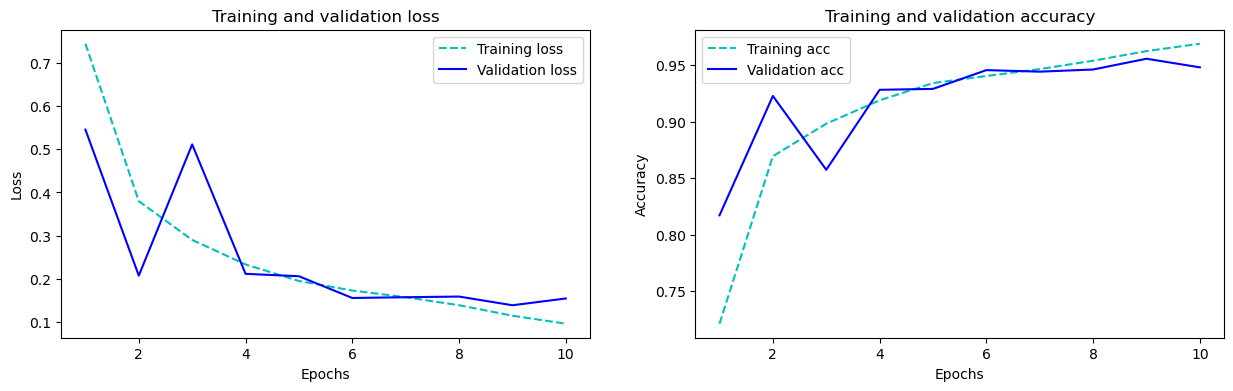

In [20]:
show_result(history)

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
test_ds2 = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    color_mode="rgb",
    seed=42,
    class_mode='sparse')

Found 4870 images belonging to 6 classes.


In [23]:
vgg16.evaluate(test_ds2)

153/153 [==============================] - 16s 103ms/step - loss: 0.1494 - accuracy: 0.9468


[0.14936943352222443, 0.9468172192573547]

In [24]:
vgg16.save('VGG16_model.h5')

153/153 [==============================] - 16s 105ms/step
Classification Report:
----------------------
                                precision    recall  f1-score   support

               Bacterial_spot       0.95      0.90      0.92       828
                 Early_blight       0.91      0.92      0.92       803
           Septoria_leaf_spot       0.91      0.91      0.91       810
                  Target_Spot       0.96      0.98      0.97       809
Tomato_Yellow_Leaf_Curl_Virus       0.98      0.98      0.98       818
                      healthy       0.98      0.99      0.98       802

                     accuracy                           0.95      4870
                    macro avg       0.95      0.95      0.95      4870
                 weighted avg       0.95      0.95      0.95      4870



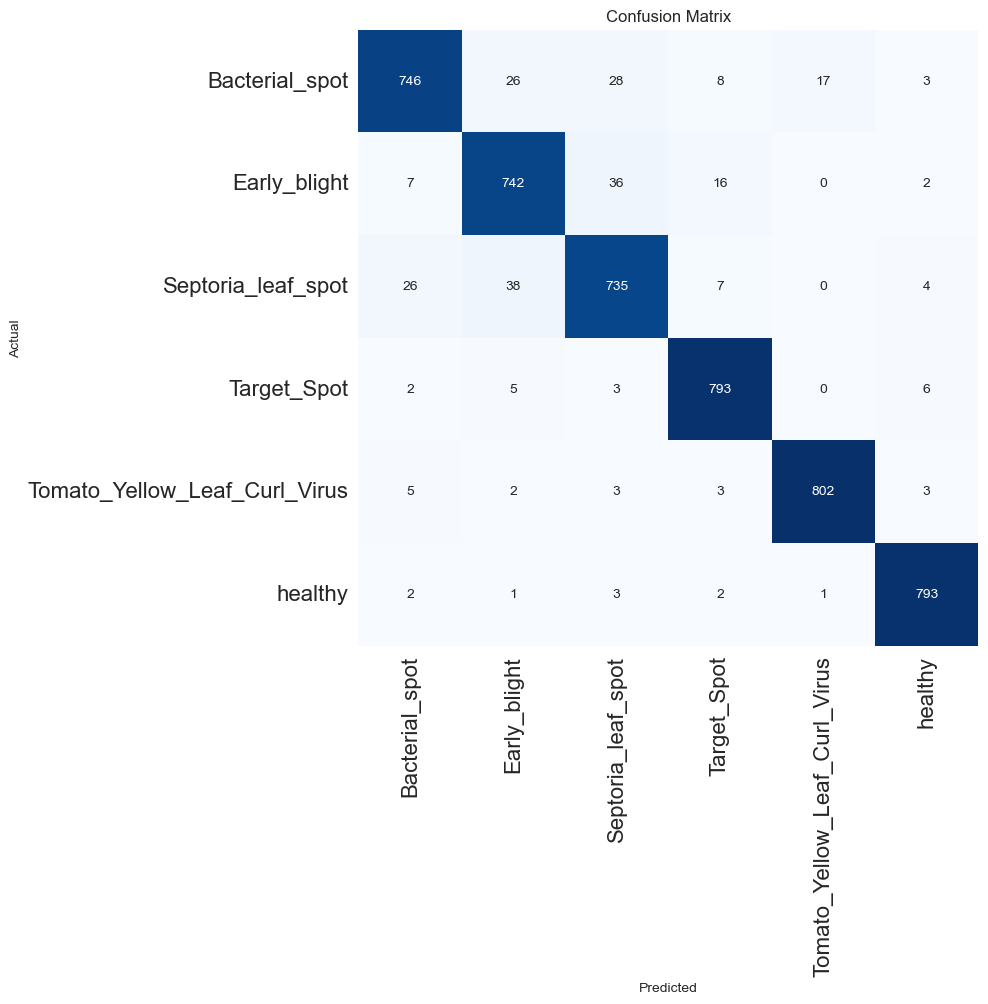

Accuracy: 0.947
Precision: 0.947
Recall: 0.947
F1 Score: 0.947


In [25]:
sns.set_style('darkgrid')
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print('Precision: %.3f' % precision_score(y_true, y_pred, average='micro'))
    print('Recall: %.3f' % recall_score(y_true, y_pred, average='micro'))
    print('F1 Score: %.3f' % f1_score(y_true, y_pred, average='micro'))


cm_cr(test_ds2, vgg16)